## Generate UMAP embeddings for top10 samples for each feature
An experiment as an alternative to UMAP on the decoder weights.


In [50]:
# average the embeddings for top10 samples for each feature, then umap that
import pandas as pd
import numpy as np
# import h5py
import umap
import os

In [51]:
name = "NOMIC_FWEDU_25k"

In [53]:
# cdf = pd.read_parquet("~/latent-scope-data/top10_64_32/clusters/cluster-005.parquet")
# cdf = pd.read_parquet("~/latent-scope-data/top10_64_32/clusters/cluster-005-labels-002.parquet")
# cdf = pd.read_parquet(f"./data/top10-{name}.parquet")
cdf = pd.read_parquet(f"./data/top10_64_32.parquet")

In [54]:
cdf.head()

,chunk_index,chunk_text,chunk_token_count,id,url,score,dump,embedding,top_acts,top_indices,feature,activation
0,0,"2019 Study Abstract\nGenomic imprinting, the m...",191,<urn:uuid:d45d32f3-aee4-464b-a7a7-4659ca6f95a5>,https://desdaughter.com/2019/01/21/genomic-imp...,2.859375,CC-MAIN-2019-18,"[0.070664756, 0.04058804, -0.1678945, -0.04720...","[0.29729074239730835, 0.23520702123641968, 0.1...","[0.0, 19961.0, 19487.0, 3596.0, 9132.0, 16563....",0,0.297291
4973,1,biological function and regulation of imprinte...,500,<urn:uuid:6492a5df-795c-4afc-8b96-adda43d374fe>,http://www.biomedcentral.com/1471-2164/10/144,2.640625,CC-MAIN-2015-11,"[0.08591175, 0.05282476, -0.1623837, -0.038760...","[0.2801821529865265, 0.21019425988197327, 0.11...","[0.0, 19961.0, 12474.0, 18618.0, 5676.0, 18178...",0,0.280182
2426,0,Molecular imprinting is a technique used to cr...,277,<urn:uuid:c4cec9f7-a221-4bac-8872-ad938bbe3b9c>,https://www.advancedsciencenews.com/new-trends...,2.796875,CC-MAIN-2021-04,"[0.06389447, 0.054419804, -0.1866366, -0.05261...","[0.27958399057388306, 0.15807494521141052, 0.1...","[0.0, 21919.0, 18672.0, 3614.0, 13226.0, 15727...",0,0.279584
44507,0,[CLS] imprinting / do not go where the path ma...,500,<urn:uuid:fd9748b7-ad11-4d51-b7d9-b5681c579e36>,https://www.windermeresun.com/2017/08/05/impri...,3.218750,CC-MAIN-2023-40,"[0.045871254, 0.0841982, -0.20583852, -0.07991...","[0.27171218395233154, 0.24269740283489227, 0.1...","[0.0, 6864.0, 8104.0, 3020.0, 15020.0, 8543.0,...",0,0.271712
7496,0,There have been a number of recent insights in...,212,<urn:uuid:40c30498-bed6-4b01-a37e-a2a1b70d80fd>,https://pure.ulster.ac.uk/en/publications/impr...,3.078125,CC-MAIN-2021-10,"[0.06898261, 0.04841869, -0.16367012, -0.05253...","[0.2717033922672272, 0.2493799477815628, 0.117...","[0.0, 19961.0, 21919.0, 14900.0, 22498.0, 1514...",0,0.271703


In [55]:
# with h5py.File("/Users/enjalot/latent-scope-data/top10_64_32/embeddings/embedding-002.h5", "r") as f:
#     embeddings = f["embeddings"][:]
# embeddings.shape

In [56]:

# Group embeddings by feature and calculate average
grouped_embeddings = cdf.groupby('feature')['embedding'].apply(lambda x: np.mean(np.stack(x.values), axis=0))

# Convert the grouped embeddings to a numpy array
averaged_embeddings = np.array(list(grouped_embeddings))

# Normalize the averaged embeddings
averaged_embeddings = averaged_embeddings / np.linalg.norm(averaged_embeddings, axis=1, keepdims=True)

print(f"Shape of averaged embeddings: {averaged_embeddings.shape}")


Shape of averaged embeddings: (24576, 768)


In [57]:
# averaged_embeddings = []
# for index_list in cdf['indices']:
#     # Grab the embeddings for the specified indices
#     selected_embeddings = embeddings[index_list]
#     # Average the embeddings
#     averaged_embedding = np.mean(selected_embeddings, axis=0)
#     # Normalize the averaged embedding
#     normalized_embedding = averaged_embedding / np.linalg.norm(averaged_embedding)
#     averaged_embeddings.append(normalized_embedding)

# averaged_embeddings = np.array(averaged_embeddings)
# averaged_embeddings.shape


In [58]:
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True,
)

In [59]:
xy = reducer.fit_transform(averaged_embeddings)

/Users/enjalot/code/latent-taxonomy/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=25, random_state=42, verbose=True)
Fri Sep  6 13:22:11 2024 Construct fuzzy simplicial set
Fri Sep  6 13:22:11 2024 Finding Nearest Neighbors
Fri Sep  6 13:22:11 2024 Building RP forest with 13 trees
Fri Sep  6 13:22:12 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Fri Sep  6 13:22:20 2024 Finished Nearest Neighbor Search
Fri Sep  6 13:22:20 2024 Construct embedding


Epochs completed:   4%| ▍          8/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  13%| █▎         26/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  23%| ██▎        46/200 [00:02]

	completed  40  /  200 epochs


Epochs completed:  33%| ███▎       66/200 [00:04]

	completed  60  /  200 epochs


Epochs completed:  43%| ████▎      86/200 [00:05]

	completed  80  /  200 epochs


Epochs completed:  53%| █████▎     106/200 [00:06]

	completed  100  /  200 epochs


Epochs completed:  63%| ██████▎    126/200 [00:07]

	completed  120  /  200 epochs


Epochs completed:  73%| ███████▎   146/200 [00:08]

	completed  140  /  200 epochs


Epochs completed:  83%| ████████▎  166/200 [00:09]

	completed  160  /  200 epochs


Epochs completed:  93%| █████████▎ 186/200 [00:11]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:11]


Fri Sep  6 13:22:36 2024 Finished embedding


In [60]:
min_values = np.min(xy, axis=0)
max_values = np.max(xy, axis=0)

# Scale the embeddings to the range [0, 1]
xy = (xy - min_values) / (max_values - min_values)

# Scale the embeddings to the range [-1, 1]
xy = 2 * xy - 1

POINT SIZE 5 for 24576 points


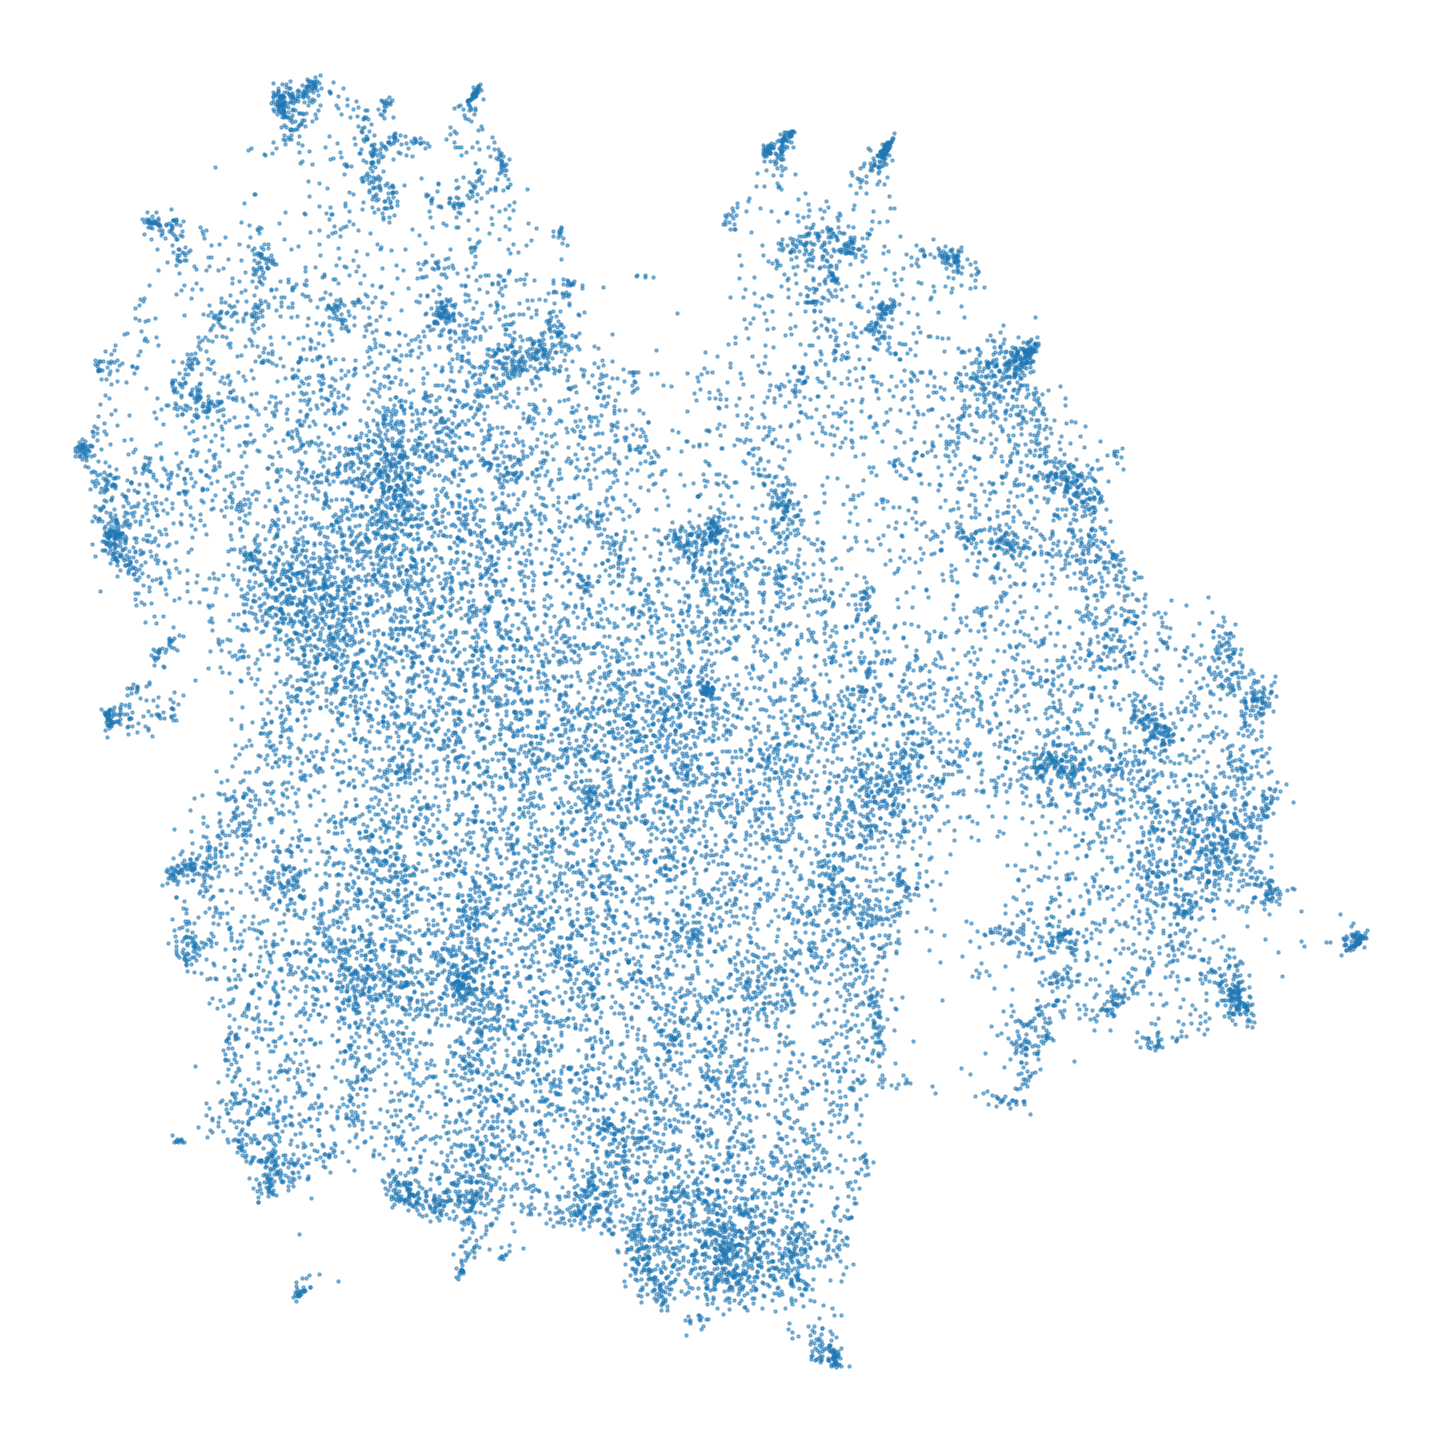

In [61]:
# generate a scatterplot of the umap embeddings and save it to a file
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14.22, 14.22))  # 1024px by 1024px at 72 dpi
point_size = 5
print("POINT SIZE", point_size, "for", xy.shape[0], "points")
plt.scatter(xy[:, 0], xy[:, 1], s=point_size, alpha=0.5)
plt.axis('off')  # remove axis
plt.gca().set_position([0, 0, 1, 1])  # remove margins
plt.show()

In [62]:
sae_id = "64_32" # because the top10 samples came from 64_32

In [63]:
df = pd.DataFrame(xy, columns=['x', 'y'])
if not os.path.exists("data"):
    os.makedirs("data")
df.to_parquet(f"data/umap-top10-{name}.parquet")
print("wrote", f"data/umap-top10-{name}.parquet")

wrote data/umap-top10-NOMIC_FWEDU_25k.parquet


In [64]:
reducer1d = umap.UMAP(
    n_neighbors=25,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    n_components=1,
    verbose=True,
)

In [65]:
order = reducer1d.fit_transform(averaged_embeddings)
order.shape

/Users/enjalot/code/latent-taxonomy/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', n_components=1, n_jobs=1, n_neighbors=25, random_state=42, verbose=True)
Fri Sep  6 13:23:00 2024 Construct fuzzy simplicial set
Fri Sep  6 13:23:00 2024 Finding Nearest Neighbors
Fri Sep  6 13:23:00 2024 Building RP forest with 13 trees
Fri Sep  6 13:23:01 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	Stopping threshold met -- exiting after 5 iterations
Fri Sep  6 13:23:10 2024 Finished Nearest Neighbor Search
Fri Sep  6 13:23:10 2024 Construct embedding


Epochs completed:   4%| ▍          8/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  10%| █          21/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▎        45/200 [00:03]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▎       65/200 [00:04]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▎      85/200 [00:05]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▎     105/200 [00:06]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▎    125/200 [00:07]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▎   145/200 [00:09]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▎  165/200 [00:10]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▎ 185/200 [00:11]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:12]


Fri Sep  6 13:23:34 2024 Finished embedding


(24576, 1)

In [70]:
dfo_a = pd.DataFrame(order, columns=['order'])
if not os.path.exists("data"):
    os.makedirs("data")
dfo_a.to_parquet(f"data/1d-order-{name}-top10.parquet")

POINT SIZE 5 for 24576 points


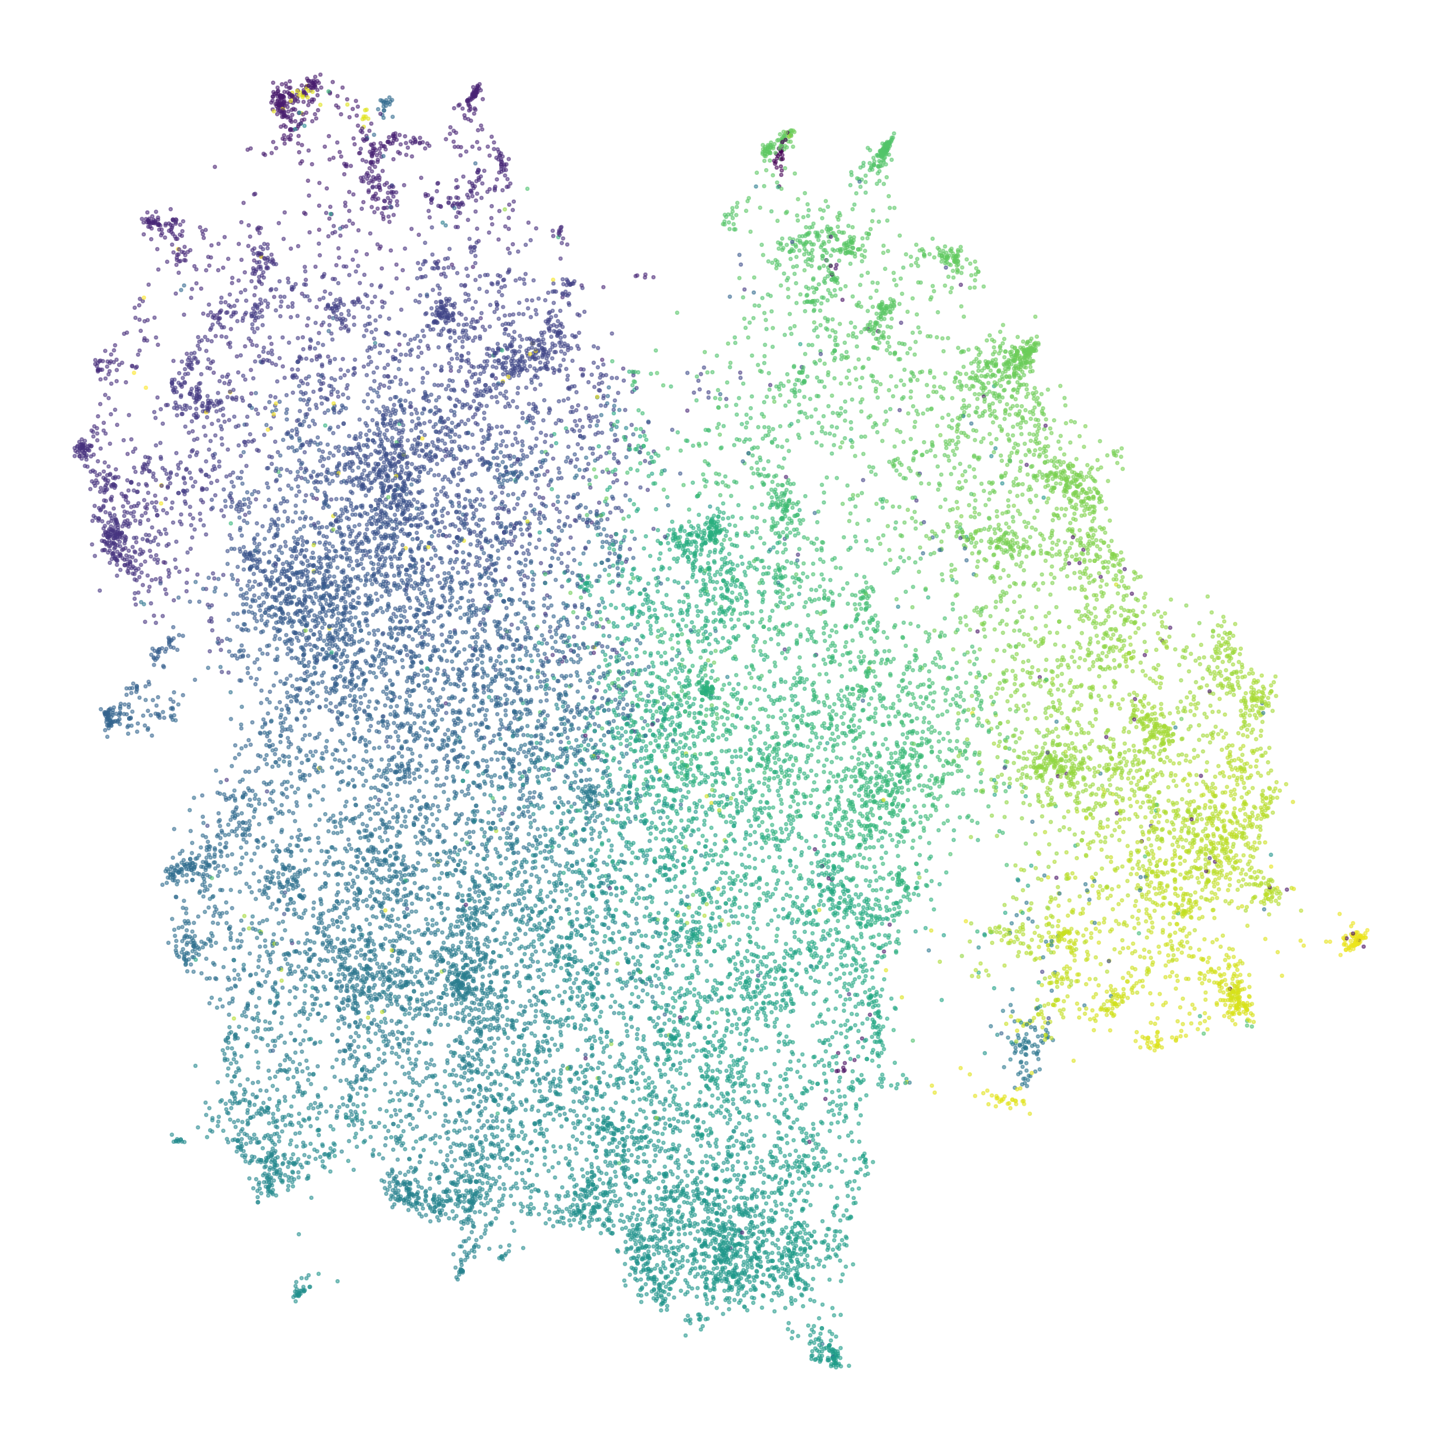

In [71]:
# generate a scatterplot of the umap embeddings and save it to a file
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14.22, 14.22))  # 1024px by 1024px at 72 dpi
point_size = 5
print("POINT SIZE", point_size, "for", xy.shape[0], "points")
# Create a colormap based on the order
cmap = plt.cm.viridis
# norm = plt.Normalize(vmin=sorted_indices.min(), vmax=sorted_indices.max())
# colors = cmap(norm(sorted_indices))
norm = plt.Normalize(vmin=order.min(), vmax=order.max())
colors = cmap(norm(order))

# Scatter plot with colors based on order
scatter = plt.scatter(xy[:, 0], xy[:, 1], s=point_size, alpha=0.5, c=colors)

# # Add a colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label('Order')

# plt.scatter(xy[:, 0], xy[:, 1], s=point_size, alpha=0.5)
plt.axis('off')  # remove axis
plt.gca().set_position([0, 0, 1, 1])  # remove margins
plt.show()

In [72]:
max(order)

array([17.813427], dtype=float32)